In [7]:
import pandas as pd
import numpy as np
import json
import itertools
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from random import sample
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
# Load data
users_role = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
user_embeddings = np.load('../../src/nlp/user_embeddings.npy', allow_pickle=True)
community_embeddings = np.load('../../src/nlp/community_embeddings.npy', allow_pickle=True)

# Load community structural info
with open('../../src/graph_dir/infomap_dir/cluster_tree_base.json', 'r') as f:
    cluster_tree = json.load(f)

# Convert embeddings to dictionaries 
user_emb_dict = {uid: np.array(emb) for uid, emb in user_embeddings}
community_emb_dict = {row[0]: np.array(row[1]) for row in community_embeddings}

# Parameters 
inter_sample_size = 1000
max_pairs_intra = 10000

In [3]:
# Computing and evaluating metrics for eco chambers classification
results = []
for comm_id, comm_info in tqdm(cluster_tree.items()):
    users = comm_info['users']
    comm_type = comm_info['type']
    conductance = comm_info['conductance']
    internal_density = comm_info['internal_density']
    modularity_gain = comm_info['modularity_gain']
    num_users = comm_info['num_users']

    # Select user embeddings in current community 
    user_embs = [user_emb_dict[u] for u in users if u in user_emb_dict]
    
    # Intra-community cosine similarity 
    if len(user_embs) > 1:
        all_pairs = list(combinations(range(len(user_embs)), 2))
        if len(all_pairs) > max_pairs_intra:
            all_pairs = sample(all_pairs, max_pairs_intra)
        intra_sims = [cosine_similarity(user_embs[i].reshape(1, -1), user_embs[j].reshape(1, -1))[0][0] for i, j in all_pairs]
    else:
        intra_sims = [1.0]

    intra_mean = np.mean(intra_sims)
    intra_std = np.std(intra_sims)

    # Inter-community cosine similarity
    external_users = [u for u in user_emb_dict.keys() if u not in users]
    if len(external_users) > inter_sample_size:
        external_users = sample(external_users, inter_sample_size)
    external_embs = [user_emb_dict[u] for u in external_users]
    
    inter_sims = []
    for ue in tqdm(user_embs):
        for ve in external_embs:
            inter_sims.append(cosine_similarity(ue.reshape(1, -1), ve.reshape(1, -1))[0][0])
    inter_mean = np.mean(inter_sims)
    inter_std = np.std(inter_sims)

    # Evaluating Hub / bridge infos
    comm_users_df = users_role[users_role['id'].isin(users)]
    num_hubs = comm_users_df['is_hub'].sum()
    num_bridges = comm_users_df['is_bridge'].sum()
    pct_bridges = num_bridges / len(users) if len(users) > 0 else 0

    # --- Echo chamber score ---
    # combined weight: similarity, structure, bridge presence
    # [0,1] normalization
    sim_score = intra_mean - inter_mean
    struct_score = (1 - conductance) * 0.5 + internal_density * 0.5
    bridge_score = 1 - pct_bridges

    echo_score = 0.5 * sim_score + 0.3 * struct_score + 0.2 * bridge_score

    # Classification
    if echo_score > 0.7:
        echo_class = "Strong Echo Chamber"
    elif echo_score > 0.4:
        echo_class = "Moderate Echo Chamber"
    else:
        echo_class = "Weak/No Echo Chamber"

    results.append({
        'community_id': comm_id,
        'community_type': comm_type,
        'num_users': num_users,
        'num_hubs': num_hubs,
        'num_bridges': num_bridges,
        'intra_mean': intra_mean,
        'inter_mean': inter_mean,
        'intra_std': intra_std,
        'inter_std': inter_std,
        'echo_score': echo_score,
        'echo_class': echo_class
    })

100%|██████████| 35/35 [31:00<00:00, 53.17s/it]


In [4]:
df_echo = pd.DataFrame(results)
df_echo.to_csv('../../src/research_question/echo_chambers_results.csv', index=False)
print(df_echo.head())

  community_id community_type  num_users  num_hubs  num_bridges  intra_mean  \
0            0    Very Strong       3508       120          174    0.547294   
1            1         Strong       1666        64          121    0.489642   
2            2         Strong       1142        48           34    0.579118   
3            3         Strong       1080        29           70    0.640398   
4            4         Strong        137         1           12    0.541577   

   inter_mean  intra_std  inter_std  echo_score             echo_class  
0    0.439390   0.128893   0.142130    0.381590   Weak/No Echo Chamber  
1    0.409471   0.124557   0.126677    0.354576   Weak/No Echo Chamber  
2    0.401598   0.135655   0.124379    0.423170  Moderate Echo Chamber  
3    0.454251   0.117906   0.158863    0.415613  Moderate Echo Chamber  
4    0.420593   0.125450   0.131156    0.351625   Weak/No Echo Chamber  


##### Cosine similarity distrubuition plots

In [8]:
# Associating user embedding with relative user row informations
if isinstance(user_embeddings, np.ndarray) and user_embeddings.dtype == object:
    user_embeddings = dict(user_embeddings.tolist())

users_role['embedding'] = users_role['id'].map(user_embeddings)

In [9]:
# Pair-users generation
N_SAMPLES = 100000  

community_users = users_role.groupby('community_id')['id'].apply(list).to_dict()

# Intra-community
intra_pairs = []
for comm, members in community_users.items():
    if len(members) < 2:
        continue
    pairs = list(itertools.combinations(members, 2))
    sampled = random.sample(pairs, min(len(pairs), N_SAMPLES // len(community_users)))
    intra_pairs.extend([(u, v, comm) for u, v in sampled])

# Inter-community
all_users = users_role['id'].tolist()
inter_pairs = []
while len(inter_pairs) < N_SAMPLES:
    u, v = random.sample(all_users, 2)
    cu, cv = users_role.loc[users_role['id'] == u, 'community_id'].item(), \
             users_role.loc[users_role['id'] == v, 'community_id'].item()
    if cu != cv:
        inter_pairs.append((u, v))

In [11]:
# Cosine similarity evaluation
# Utility functions that computes cosine similarity between two embeddings
def cosine(u, v):
    u, v = np.array(u), np.array(v)
    return cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]
emb_dict = dict(zip(users_role['id'], users_role['embedding']))

# Intra-community similarities
intra_sims = [cosine(emb_dict[u], emb_dict[v]) for u, v, _ in intra_pairs]

# Inter-community similarities
inter_sims = [cosine(emb_dict[u], emb_dict[v]) for u, v in inter_pairs]

print(f"Intra-community sample size: {len(intra_sims)}")
print(f"Inter-community sample size: {len(inter_sims)}")

Intra-community sample size: 16223
Inter-community sample size: 100000


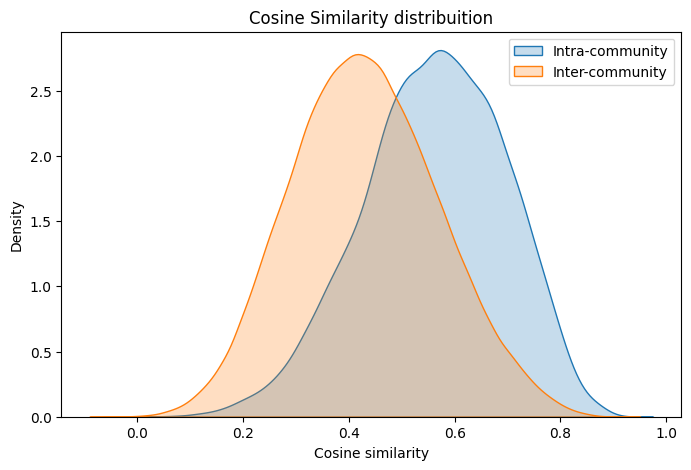

In [12]:
plt.figure(figsize=(8,5))
sns.kdeplot(intra_sims, label="Intra-community", fill=True)
sns.kdeplot(inter_sims, label="Inter-community", fill=True)
plt.xlabel("Cosine similarity")
plt.ylabel("Density")
plt.title("Cosine Similarity distribuition")
plt.legend()
plt.show()